# Introduction

This is a simple model for processing natural language use to predict the SMS spam filter
* Using Stopwords from nltk library to remove common words
* Using Vectorizer to pre-processing data
* Using MultinomialNB from Naive Bayes from Scikit-Learn to train, predict and evaluate the model </p>

Data Pipeline is added on to store a pipeline of workflow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# For those who do not have nltk library in your computer (I'm already have)
# We will download stopwords from nltk library

# !conda install nltk 
# import nltk 
# nltk.download()

In [3]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Data Preparation

In [4]:
import gdown
from IPython.display import clear_output

id = '1v24XMvh_Gigoxy__fUzWJtn3i_PpDaCL'
url = 'https://drive.google.com/uc?id={}'.format(id)
output = 'SMS_Spam_Collection'

gdown.download(url, output)
clear_output()

In [5]:
message = [line.rstrip() for line in open('SMS_Spam_Collection')]

message[:5]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though"]

A collection of texts is also sometimes called "corpus".

In [6]:
print(len(message))

5574


In [7]:
for index, mess in enumerate(message[:5]):
    print(index, mess)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




We can split dataset into DataFrame like:

In [8]:
data = pd.read_csv('SMS_Spam_Collection', sep='\t', names=['Label', 'Message'])

data.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# EDA

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
data.describe()

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
data.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

<p> Thinking about feature engineering, we should use feature such as length of message.</p>
Let's make a new column to detect how long the text messages are:

In [12]:
data['Length'] = data['Message'].apply(len)

data.head()

,Label,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Let's make some data visualization about this feature

<AxesSubplot:ylabel='Frequency'>

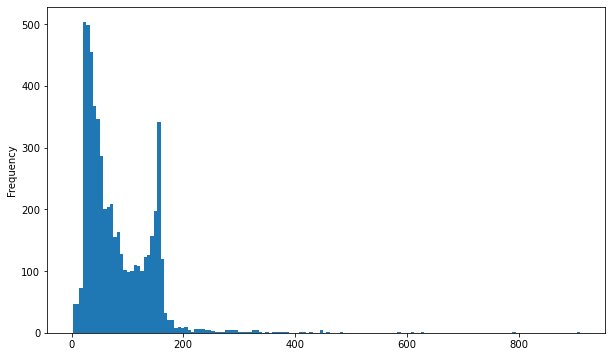

In [13]:
plt.figure(figsize=(10,6))

data['Length'].plot(bins=150, kind='hist')

Play with bins size (above 150), we can see that message length may be a good feature engineering to working to !

In [14]:
data['Length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: Length, dtype: float64

In [15]:
data[data['Length'] == 910]

,Label,Message,Length
1085,ham,For me the love should start with attraction.i...,910


Looks like we have some sort of very long texts such as: 1 around 900 and 1 around 800. </p> But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

<AxesSubplot:xlabel='Length', ylabel='Count'>

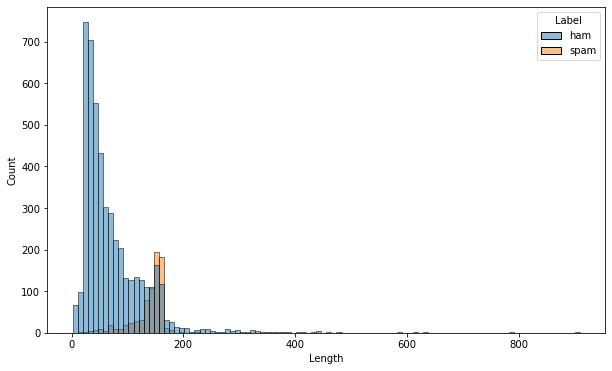

In [16]:
plt.figure(figsize=(10,6))

sns.histplot(x='Length', hue='Label', data=data, bins=100)

Interesting!!! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

# Data Pre-processing

We will describe a function to process message:
1. Remove all punctuation
2. Remove all stopwords
3. Returns a list of the cleaned text

In [17]:
def text_processing(message):
    nopunc = [char for char in message if char not in string.punctuation] # remove all punctuation
    nopunc = ''.join(nopunc)
    clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('English')] # remove all stopwords
    return clean_mess # returns a list of the cleaned text

In [18]:
data['Message'].head().apply(text_processing)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: Message, dtype: object

## Vectorization

Now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.</p>
We'll do that in three steps using the bag-of-words model:</p>
1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [19]:
bow_transformer = CountVectorizer(analyzer=text_processing)
bow_transformer.fit(data['Message'])

CountVectorizer(analyzer=<function text_processing at 0x000001DCD975BDC0>)

In [20]:
print('Number of cleanned unique words after text_processing:', len(bow_transformer.vocabulary_))

Number of cleanned unique words after text_processing: 11425


Let's take one text message and get its bag-of-words counts as a vector

In [21]:
example = data['Message'][13]
example

"I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times."

In [22]:
bow_of_example = bow_transformer.transform([example])
print(bow_of_example)
print('----------------')
print(bow_of_example.shape)

  (0, 2394)	1
  (0, 5075)	1
  (0, 5166)	1
  (0, 6751)	1
  (0, 6929)	1
  (0, 7089)	1
  (0, 9092)	2
  (0, 9422)	1
  (0, 9597)	1
  (0, 10295)	1
  (0, 10392)	1
  (0, 10491)	1
  (0, 11142)	1
  (0, 11145)	1
  (0, 11154)	1
----------------
(1, 11425)


It means example message contains 15 unique words in bag_of_words </p>
Let's see what they are:

In [23]:
print(bow_transformer.get_feature_names_out()[2394])
print(bow_transformer.get_feature_names_out()[10491])

Ive
times


Now we can use bow_transformer to transform the entire DataFrame of messages

In [24]:
bow_all_messages = bow_transformer.transform(data['Message'])

print('Shape of Sparse Matrix:', bow_all_messages.shape)
print('Number of non-zero:', bow_all_messages.nnz)

Shape of Sparse Matrix: (5572, 11425)
Number of non-zero: 50548


We can compute % of non-zero vs rest

In [25]:
proba = (100.0 * bow_all_messages.nnz / (bow_all_messages.shape[0] * bow_all_messages.shape[1]))
print('Probability:', proba)

Probability: 0.07940295412668218


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

In [26]:
tf_idf_tranform = TfidfTransformer()

tf_idf_tranform.fit(bow_all_messages)

TfidfTransformer()

Let's test with bow_of_example

In [27]:
tf_idf_example = tf_idf_tranform.transform(bow_of_example)
print(tf_idf_example)

  (0, 11154)	0.21566478164069935
  (0, 11145)	0.18471478040825087
  (0, 11142)	0.22457604785901872
  (0, 10491)	0.20995122219423834
  (0, 10392)	0.23997806395818444
  (0, 10295)	0.16323710179735187
  (0, 9597)	0.25671781657187465
  (0, 9422)	0.17102560039767398
  (0, 9092)	0.4868614548432374
  (0, 7089)	0.19068945672611662
  (0, 6929)	0.2927193346536865
  (0, 6751)	0.2927193346536865
  (0, 5166)	0.2927193346536865
  (0, 5075)	0.2794322455034306
  (0, 2394)	0.19217925845075481


This is TF-IDF scores of each words in example

Now let's tranform entire of message

In [28]:
tf_idf_all_message = tf_idf_tranform.transform(bow_all_messages)
print(tf_idf_all_message.shape)

(5572, 11425)


# Training the model

I will use MultinomialNB for this problem because this model is mainly used in text classification

In [29]:
model = MultinomialNB()

model.fit(tf_idf_all_message, data['Label'])

MultinomialNB()

# Predictions & Evaluations

Let's try classifying our single random message:

In [30]:
print('Predict:', model.predict(tf_idf_example)[0])
print('Expected:', data['Label'][13])

Predict: ham
Expected: ham


Great!!!

In [31]:
y_predict = model.predict(tf_idf_all_message)
y_predict

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [32]:
y_target = data['Label']

print(classification_report(y_target, y_predict))
print(confusion_matrix(y_target, y_predict))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572

[[4825    0]
 [ 115  632]]


Because we just test accuracy on traing data. Let's see what we can do more:

### Train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data['Message'], data['Label'], test_size=0.2, random_state=101)

### Creating Data pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow.</p> 
This will allow us to set up all the transformations that we will do to the data for future use.

In [34]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),
    ('tf_idf', TfidfTransformer()),
    ('model', MultinomialNB())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x000001DCD975BDC0>)),
                ('tf_idf', TfidfTransformer()), ('model', MultinomialNB())])

In [35]:
y_predict = pipeline.predict(X_test)

print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       980
        spam       1.00      0.66      0.79       135

    accuracy                           0.96      1115
   macro avg       0.98      0.83      0.89      1115
weighted avg       0.96      0.96      0.95      1115

[[980   0]
 [ 46  89]]


# DONE